**Поведение пользователей мобильного приложения**

**Цель исследования**: изучение поведения пользователей по логам, а также изучение результата А/А/В тестирования по изменению шрифта в приложении. 

**С О Д Е Р Ж А Н И Е**: 
<a id='top'></a>

1. [Загрузка и изучение информации о данных.](#import)


2. [Подготовка данных для анализа.](#preparing)


3. [Изучение и проверка данных.](#learning)


4. [Изучение воронки событий.](#funnel)


5. [Изучение результатов эксперимента.](#aab)


6. [Вывод.](#total)


7. [Рекомендации.](#recommendation)

# Загрузка и изучение данных
<a id='import'></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings; warnings.filterwarnings(action = 'ignore') 
from scipy import stats as st
import numpy as np

In [2]:
try:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/logs_exp.csv', sep='\t')
except:
    data = pd.read_csv('logs_exp.csv', sep='\t')
data.head()
data_copy = data.copy()

In [3]:
# Получаю информацию о датасете
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [4]:
# Переименовываю столбцы
data = data.rename(
    columns={
        'EventName': 'event',
        'DeviceIDHash': 'user_id', 
        'EventTimestamp': 'event_time', 
        'ExpId': 'group_id'
    }
)
data.head(1)

,event,user_id,event_time,group_id
0,MainScreenAppear,4575588528974610257,1564029816,246


In [5]:
# Проверяю, какие есть события и группы
# Списками, чтобы разбить данные запятой.
# Мне так приятнее видеть
print('События:', list(data['event'].unique()))
print()
print('Группы:', list(data['group_id'].unique()))

События: ['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear', 'OffersScreenAppear', 'Tutorial']

Группы: [246, 248, 247]


In [6]:
# Смотрю на типы данных в датасете
data.dtypes

event         object
user_id        int64
event_time     int64
group_id       int64
dtype: object

In [7]:
# Проверяю явные дубликаты
print('Число дубликатов:', data.duplicated().sum())
print()
print('Процент дубликатов от всех данных:', \
      round(data.duplicated().sum() / len(data) * 100, 2))

Число дубликатов: 413

Процент дубликатов от всех данных: 0.17


**Изучение информации о данных дало следующее**: 


1. Всего записей 244126.


2. Пропусков не замечено.


3. Есть явные дубликаты - 0.17%.


4. Событий всего 5.


5. Три группы. 


6. Время в датасете в секундах от сотворения мира (1.01.1970), а тип данных int64, что требует исправления.


**Нужно сделать**: 


1. Поменять названия столбцов. Уже сделано.


2. Изменить тип данных даты.


3. Создать отдельные столбцы с датой и времнем + с датой. 


4. Удалить дубликаты. 


5. Найти, если есть, пользователей, попавших в несколько групп.







# Подготовка данных для анализа
<a id='preparing'></a>

In [8]:
# Наперво меняю тип данных в столбце с датой.
data['event_time'] = pd.to_datetime(data['event_time'], unit='s')

# И добавляю поле с датой:
data['date'] = pd.to_datetime(data['event_time'].dt.date)
data.head()

,event,user_id,event_time,group_id,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


In [9]:
# Удаляю дубликаты
data = data.drop_duplicates().reset_index(drop=True)
len(data)

243713

In [10]:
# Проверяю, нет ли пользователей, которые попали в несколько групп
print(len(np.intersect1d(data.query('group_id == 246')['user_id'].unique(), 
                   data.query('group_id == 247')['user_id'].unique())))

print(len(np.intersect1d(data.query('group_id == 246')['user_id'].unique(), 
                   data.query('group_id == 248')['user_id'].unique())))

print(len(np.intersect1d(data.query('group_id == 248')['user_id'].unique(), 
                   data.query('group_id == 247')['user_id'].unique())))

0
0
0


In [11]:
# Подсказали, что можно сделать проще
data.groupby('user_id')['group_id'].nunique().reset_index().query('group_id > 1')

,user_id,group_id


Пользователей, которые попали бы в несколько групп, нет. Дубликаты удалены. Изменён тип данных в столбце `event_date`, а также создан столбец `date`, содержащий лишь дату.

# Изучение данных
<a id='learning'></a>

Не очень ясно, что значит "всего событий" в задании, потому посчитал и сами события, и их типы.

In [12]:
print('Число всех событий: %d. Число типов событий: %d. \
Количество пользователей: %d.' 
      % (len(data),
      data['event'].nunique(),
      data['user_id'].nunique()))

print('Среднее число событий на пользвателя: %s.' 
      % round((len(data) / data['user_id'].nunique()), 3))

Число всех событий: 243713. Число типов событий: 5. Количество пользователей: 7551.
Среднее число событий на пользвателя: 32.276.


Данными за какой период я располагаю? 

In [13]:
min_date = min(data['date'])
min_date

Timestamp('2019-07-25 00:00:00')

In [14]:
max_date = max(data['date'])
max_date

Timestamp('2019-08-07 00:00:00')

Данные содержат записи о событиях с 25 июля 2019 года по 7 августа 2019 года.

Далее требуется построить гистограмму распределения записей лога по дате и времени

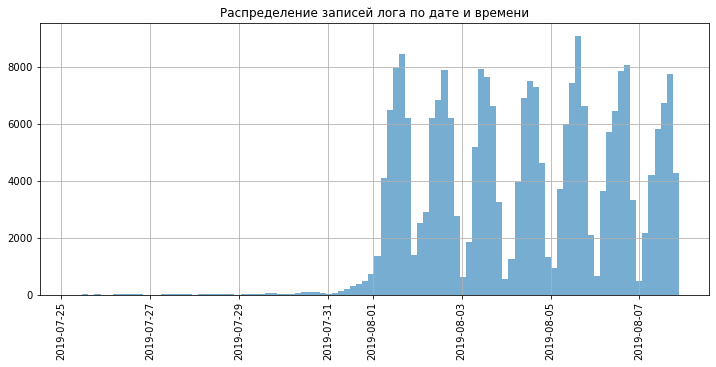

In [15]:
plt.title('Распределение записей лога по дате и времени')
data['event_time'].hist(bins=100, xrot = 90, figsize=(12, 5), alpha=0.6)
plt.show()

Данные за июль не являются полными и потому их нужно отмести. 

In [16]:
# Записываю инфу о числе данных до коррекции
entries_before = len(data)
users_before = data['user_id'].nunique()

In [17]:
# Удаляю данные до 1 августа
data = data = data[data['event_time'] >= '2019-08-01']

In [18]:
# Вывожу данные о числе записей и пользователей до коррекции и после
print('До корректировки данных всего записисей: %d, \
всего пользователей: %d.' % (entries_before, users_before))
print()
print('После корректировки данных всего записей: %d, \
всего пользователей: %d.' % (len(data), data['user_id'].nunique()))

До корректировки данных всего записисей: 243713, всего пользователей: 7551.

После корректировки данных всего записей: 240887, всего пользователей: 7534.


In [19]:
# Считаю разницу между новыми данными и старыми
print('Удалено всего записей: %d, всего пользователей: %d.' 
      % (entries_before - len(data), 
         users_before - data['user_id'].nunique(),
        )
     )
print('Отноешение удалённых записей: %s, пользователей: %s'
     % (round((len(data) - entries_before) / entries_before * 100, 2),  
      round((data['user_id'].nunique() - users_before) / users_before * 100, 2)))

Удалено всего записей: 2826, всего пользователей: 17.
Отноешение удалённых записей: -1.16, пользователей: -0.23


In [20]:
# Проверяю число пользователей из всех групп
data.groupby('group_id').agg({'user_id': 'nunique'}).reset_index()

,group_id,user_id
0,246,2484
1,247,2513
2,248,2537


In [21]:
# Смотрю число событий по группам
data.groupby('group_id').agg({'event': 'count'}).reset_index()

,group_id,event
0,246,79302
1,247,77022
2,248,84563


Были отсечены 17 пользователей и 2826 записей, что составило 0.23 и 1.16 процента соответственно. 

Количество пользователей и записей в трёх группах можно назвать близким друг другу.


|Что изменили |Было  |Стало |Разница |В процентах|
|------------:|-----:|-----:|-------:|----------:|
|Записи       |243713|240887|2826    |1.16       |
|Пользоваталей|7551  |7534  |17      |0.23       |


# Изучение воронки событий
<a id='funnel'></a>

## Изучение частоты событий

In [22]:
# Создаю переменную с счётчиком событий
events = (data
          .groupby('event')
          .agg({'user_id':"count"})
          .reset_index()
          .rename(columns={'user_id' : 'events_amount'})
          .sort_values(by='events_amount', ascending=False)
          
         )
events

,event,events_amount
1,MainScreenAppear,117328
2,OffersScreenAppear,46333
0,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


## Подсчёт числа пользователей,  совершавших то или иное событие. Расчёт доли пользоваталей, которые совершили событие хотя бы раз

In [23]:
# Создаю переменную с счётчиком пользователей на событие
users = (data
          .groupby('event')
          .agg({'user_id':"nunique"})
          .reset_index()
          .rename(columns={'user_id' : 'users_amount'})
          .sort_values(by='users_amount', ascending=False)
          
         )
users

,event,users_amount
1,MainScreenAppear,7419
2,OffersScreenAppear,4593
0,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539
4,Tutorial,840


In [24]:
# Вывожу долю пользователей, совершивших событие хотя бы один раз
users['percents'] = round(users['users_amount'] / data['user_id'].nunique() * 100, 2)
users

,event,users_amount,percents
1,MainScreenAppear,7419,98.47
2,OffersScreenAppear,4593,60.96
0,CartScreenAppear,3734,49.56
3,PaymentScreenSuccessful,3539,46.97
4,Tutorial,840,11.15


**Разбивка событий по числу пользователей**. Сколько человек совершили и какой процент от общего числа пользователей.


| Событие                                         | Совершили                |
| ----------------------------------------------: | :------------------------|
| Просмотр главной страницы (MainScreenAppear)	  | 7419 человек или 98.47%  |
| Просмотр экрана предложений (OffersScreenAppear)| 4593 человека или 60.96% |
| Просмотр экрана инфо о товаре (CartScreenAppear)| 3734 человека или 49.56% |
| Инфо об успехе оплаты (PaymentScreenSuccessful) | 3539 человек или 46.97%  |
| Обучение / FAQ / Инструкции (Tutorial)          | 840 человек или 11.15%   |


## Порядок событий


Можно сделать вывод, что события происходят в следующем порядке: просмотр основной страницы, изучение предложений, открытие страницы товара, покупка. 


Просомотр обучения явно не зависит от других шагов и не может быть включён в воронку.


## Построение воронки и расчёт процентного отношения отсева пользователей по шагам

In [25]:
from plotly import graph_objects as go
funnel = users[users['event'] != 'Tutorial']
funnel

,event,users_amount,percents
1,MainScreenAppear,7419,98.47
2,OffersScreenAppear,4593,60.96
0,CartScreenAppear,3734,49.56
3,PaymentScreenSuccessful,3539,46.97


In [26]:
# px.funnel?

In [27]:
# go.Figure?

In [41]:
# Воронка с данными отношений с предыдущему шагу
fig = go.Figure(go.Funnel(y = funnel['event'],
                          x = funnel['users_amount'],
                          # title='Воронка событий, число пользователей', 
                          textposition = 'inside',
                          textinfo = 'value + percent previous'))
fig.update_layout(title='Воронка продаж с отсеом относительно пред. этапа')
fig.show()

In [42]:
# Воронка с данными отношений к общему числу пользователей
fig = go.Figure(go.Funnel(y = funnel['event'],
                          x = funnel['users_amount'],
                          # title='Воронка событий, число пользователей', 
                          textposition = 'inside',
                          textinfo = 'value + percent initial'))
fig.update_layout(title='Воронка продаж с отсеом относительно общего числа пол-лей')
fig.show()

In [30]:
# Чтобы посчитать процент пользователей, которые совершили покупку,
# создаю сводную, из которой и сделаю расчёт 
users_temp = data.pivot_table(
    index='user_id', 
    columns='event', 
    values='event_time',
    aggfunc='min'
)

In [31]:
round(users_temp['PaymentScreenSuccessful'].count() 
      / users_temp['MainScreenAppear'].count() * 100, 2)

47.7

Исходя из представленных данных, можно сделать следующий вывод: от пользователей, увидевших главную страницу / экран до предложений доходит лишь 62%. То есть, 38% пользователей теряется именно на этом этапе. Далее потери идут менее высокие: 19% на шаге от предложения до изучения товара. И совсем низкий показатель потерь: всего 5% пользователей от тех, кто изучил товар, не доходят до покупки. Это очень круто. 


Стоит изучить предметно, почему пользователи не могут познакомиться с предложениями и довольно много теряется на пути от предложения к товару.


Что касается отношения купивших к тем, кто в принципе посетил главную, то это 47.7%. Нужно уточнить у бизнеса, насколько плохое это число. 

# Изучение результатов эксперимента
<a id='aab'></a>

In [32]:
# Число пользователей в каждой группе
data.groupby('group_id').agg({'user_id': 'nunique'}).reset_index()

,group_id,user_id
0,246,2484
1,247,2513
2,248,2537


## Проверка двух контрольных групп на отсутствие различий

Для проверки использую z-критерий Фишера. Для успешного применения требуется, чтобы исходные данные имели нормальное распределение и была известна дисперсия генеральной совокупности.

У нас есть три группы, которые нужно сравнить. В них есть 4 события. Итого, сравниваем 246 и 247, затем каждую из них с 248-й, а потом сочетание 246 и 247 с 248-й. Сравнений много. Потому лучше написать функцию.


Так как есть вероятность получить ошибку за счёт большого числа сранвнений, нужно применить поправку. Буду применять метод Шидака и установлю число сравнений - 16. 

Функция принимает два датафрейма с данными и проверяет наличие статзначимых различий между пользователями, совершившими заданное событие. Параметры:

- `data_1`, `data_2` - датафреймы;

- `event` - событие;

- `alpfa` - критический уровень статистической значимости;

- `n` - число сравнений для применения поправки Шидака для критического уровня статистической значимости.

In [33]:
def z_test(data_1, data_2, event, alpha, n):
    
    # Уровень значимости с поправкой Шидака
    alpha_sh = 1 - (1 - alpha)**(1/n)
    
    # Число пользоваталей в каждой группе
    user_number = np.array([data_1['user_id'].nunique(),  
                            data_2['user_id'].nunique()])
    
    # Число пользователей, которые совершили событие
    committed_event = np.array([data_1[data_1['event'] == event]['user_id'].nunique(),   
                                data_2[data_2['event'] == event]['user_id'].nunique()]) 
    
    # Пропорции успехов в группах
    p1 = committed_event[0]/user_number[0]   
    p2 = committed_event[1]/user_number[1]
    
    # Пропорция успехов в объединённых данных
    p_combined = ((committed_event[0] + committed_event[1]) 
                  / (user_number[0] + user_number[1])) 

    diff = p1 - p2 # разница пропорций в датасетах

    # Статистика в стандартных отклонениях стандартного нормального распределения
    z_value = diff /  np.sqrt(p_combined * (1 - p_combined) * (1/user_number[0] + 1/user_number[1]))

    # Стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)  
    
    # Так как тест двусторонний, требуется удвоить результат
    p_value = (1 - distr.cdf(abs(z_value))) * 2   
    
    print('Событие:', event)
    print('p-значение: ', p_value)

    if p_value < alpha_sh:
        print('Отвергаем нулевую гипотезу: между группами есть разница')
    else:
        print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными')

In [34]:
# Объединяю в группу воронки
funnel_group = (data.
          groupby(['event', 'group_id']).
          agg({'user_id': 'nunique'}).
          reset_index().
          rename(columns={'user_id' : 'users_amount'}).
          sort_values(by=['group_id','users_amount'], ascending=False))

funnel_group = funnel_group[funnel_group['event'] != 'Tutorial']
funnel_group

,event,group_id,users_amount
5,MainScreenAppear,248,2493
8,OffersScreenAppear,248,1531
2,CartScreenAppear,248,1230
11,PaymentScreenSuccessful,248,1181
4,MainScreenAppear,247,2476
7,OffersScreenAppear,247,1520
1,CartScreenAppear,247,1238
10,PaymentScreenSuccessful,247,1158
3,MainScreenAppear,246,2450
6,OffersScreenAppear,246,1542


Проверяю гипотезы.

Н0: Данные контрольных групп одинаковы, различий нет.

Н1: Данные контрольных групп различаются.

In [35]:
for event in funnel_group['event'].unique():
    z_test(data[data['group_id'] == 246], data[data['group_id'] == 247], event,.05, 16)
    print()

Событие: MainScreenAppear
p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Событие: OffersScreenAppear
p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Событие: CartScreenAppear
p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Событие: PaymentScreenSuccessful
p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными



Результат А/А-теста говорит, что оснований считать данные различными нет. А потому можно провести тест А/В. 

## Выбор самого популярного события

*Это вообще о чём? Предполагаю, что самым популярным можно назвать лишь посещение главной*

In [36]:
fig = go.Figure()

fig.add_trace(go.Funnel(name = '246',
                        y = funnel_group.query('group_id == 246')['event'],
                        x = funnel_group.query('group_id == 246')['users_amount'],
                        opacity = 0.6,
                        textposition = 'inside',
                        textinfo = 'value + percent previous'))

fig.add_trace(go.Funnel(name = '247',
                        y = funnel_group.query('group_id == 247')['event'],
                        x = funnel_group.query('group_id == 247')['users_amount'],
                        opacity = 0.6,
                        textposition = 'inside',
                        textinfo = 'value + percent previous'))


fig.add_trace(go.Funnel(name = '248',
                        y = funnel_group.query('group_id == 248')['event'],
                        x = funnel_group.query('group_id == 248')['users_amount'],
                        opacity = 0.6,
                        textposition = 'inside',
                        textinfo = 'value + percent previous'))
                        
fig.show()


Самым популярным событием является посещение главного экрана / страницы. Не удивительно. Это раньше мы уже видели в цифрах. Ниже проверим различия на статистическую достоверность.

## Проверка тестовой и контрольных групп на различия

Теперь проверяю различия между контрольными группами и экспериментальной. Гипотезы те же. 

Н0: Данные контрольных групп одинаковы, различий нет. 

Н1: Данные контрольных групп различаются.

In [37]:
for event in funnel_group['event'].unique():
    z_test(data[data['group_id'] == 246], data[data['group_id'] == 248], event, .05, 16)
    print()

Событие: MainScreenAppear
p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Событие: OffersScreenAppear
p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Событие: CartScreenAppear
p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Событие: PaymentScreenSuccessful
p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными



In [38]:
for event in funnel_group['event'].unique():
    z_test(data[data['group_id'] == 247], data[data['group_id'] == 248], event, .05, 16)
    print()

Событие: MainScreenAppear
p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Событие: OffersScreenAppear
p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Событие: CartScreenAppear
p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Событие: PaymentScreenSuccessful
p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными



In [39]:
for event in funnel_group['event'].unique():
    z_test(data[data['group_id'] != 248], data[data['group_id'] == 248], event, .05, 16)
    print()

Событие: MainScreenAppear
p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Событие: OffersScreenAppear
p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Событие: CartScreenAppear
p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Событие: PaymentScreenSuccessful
p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными



Сравнение групп 246 и 248 говорит, что разницы в них не наблюдается. То же с группами 247 и 248. Сравнение объединённых групп 246 и 247 с группой 248 также не даёт причин отрицать гипотезу о равенстве. 

Вывод из исследования: изменение шрифта не повлияло на принятие решений пользователями. Ни отрицательно, ни положительно. 

# Вывод
<a id='total'></a>

1. Предоставленные для изучения данные дают повод сказать, что изменение шрифта не отразилось на поведении пользователей. Ни переходы по предложенным товарам, ни просмотры самих товаров, ни число покупок не изменились. 

<hr>

2. В ходе исследования обнаружено, что есть большие потери пользователей на этапе просмотра главной. До просмотра предложений доходит лишь 62% пользователей. 38% мы теряем.  

    Меньшие потери на шаге изучения предложений. Здесь мы теряем 19% пользователей.
    
    На этапе изучения товара потери минимальны - 5%. Остальные 95% конвертируются в покупателей. 

    Все проценты в этом пункте считаются от числа пользователей на предыдущем шаге.
    
<hr>

3. Покупателями стали 47.7% пользователей. 





Для анализа были использованы данные о 7419 пользователях:

- из них 62% (4593 человека) просмотрели страницу предложений;

- из них 50% (3734 человека) просмотрели страницу товара;

- из них 48% (3539 человек) купили товары.

<hr>

Пользователи были разделены на три группы, две из которых - контрольные. Группы и данные по ним представлены в таблице ниже.


|Группа|Число пользователей|Главная|Предложения|Товар     |Покупка   |
|:----:|:-----------------:|:-----:|:---------:|:--------:|:--------:|
|246   |2450               |2450   |1542 : 63% |1266 : 82%|1200 : 95%|
|247   |2476               |2476   |1520 : 61% |1238 : 81%|1158 : 94%|
|248   |2493               |2493   |1531 : 61% |1230 : 80%|1181 : 96%|


- Для проверки равенства выборок был использован z-критерий Фишера.


- Уровень значимости был установлен на 0.05 с корректировкой Шидака для снижения возможности ошибки при множественной проверке гипотез. 


- Всего было проведено 16 проверок: по 4 критерия в 4 группах (две контрольные, их объединение и тестовая). 


- При установке уровня значимости `alpha` в 0.01 данные не изменились. 




# Рекомендации
<a id='recommendation'></a>

На основе полученных результатов можно рекомендовать проверить работу приложения. Нельзя исключать, что потеря 38% пользователей связана с ошибками в работе приложения. 


Также стоит изучить причины, по которым после посещения предложений могут теряться 19% пользователей. Возможно, показатель получится снизить. 

[top](#top)